In [1]:
words = open('names.txt', 'r').read().splitlines()

In [2]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
len(words)

32033

In [4]:
min(len(word) for word in words)

2

In [5]:
max(len(word) for word in words)

15

In [6]:
words[0][1:]

'mma'

In [7]:
b = {}
for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1

In [8]:
sorted(b.items(), key=lambda kv: -kv[1])

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('<S>', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '<E>'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('<S>', 'j'), 2422),
 (('o', 'n'), 2411),
 (('h', '<E>'), 2409),
 (('r', 'a'), 2356),
 (('a', 'h'), 2332),
 (('h', 'a'), 2244),
 (('y', 'a'), 2143),
 (('i', 'n'), 2126),
 (('<S>', 's'), 2055),
 (('a', 'y'), 2050),
 (('y', '<E>'), 2007),
 (('e', 'r'), 1958),
 (('n', 'n'), 1906),
 (('y', 'n'), 1826),
 (('k', 'a'), 1731),
 (('n', 'i'), 1725),
 (('r', 'e'), 1697),
 (('<S>', 'd'), 1690),
 (('i', 'e'), 1653),
 (('a', 'i'), 1650),
 (('<S>', 'r'), 1639),
 (('a', 'm'), 1634),
 (('l', 'y'), 1588),
 (('<S>', 'l'), 1572),
 (('<S>', 'c'), 1542),
 (('<S>', 'e'), 1531),
 (('j', 'a'), 1473),
 (

In [9]:
import torch

In [10]:
N = torch.zeros((27, 27), dtype=torch.int32)

In [11]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [12]:
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1
    

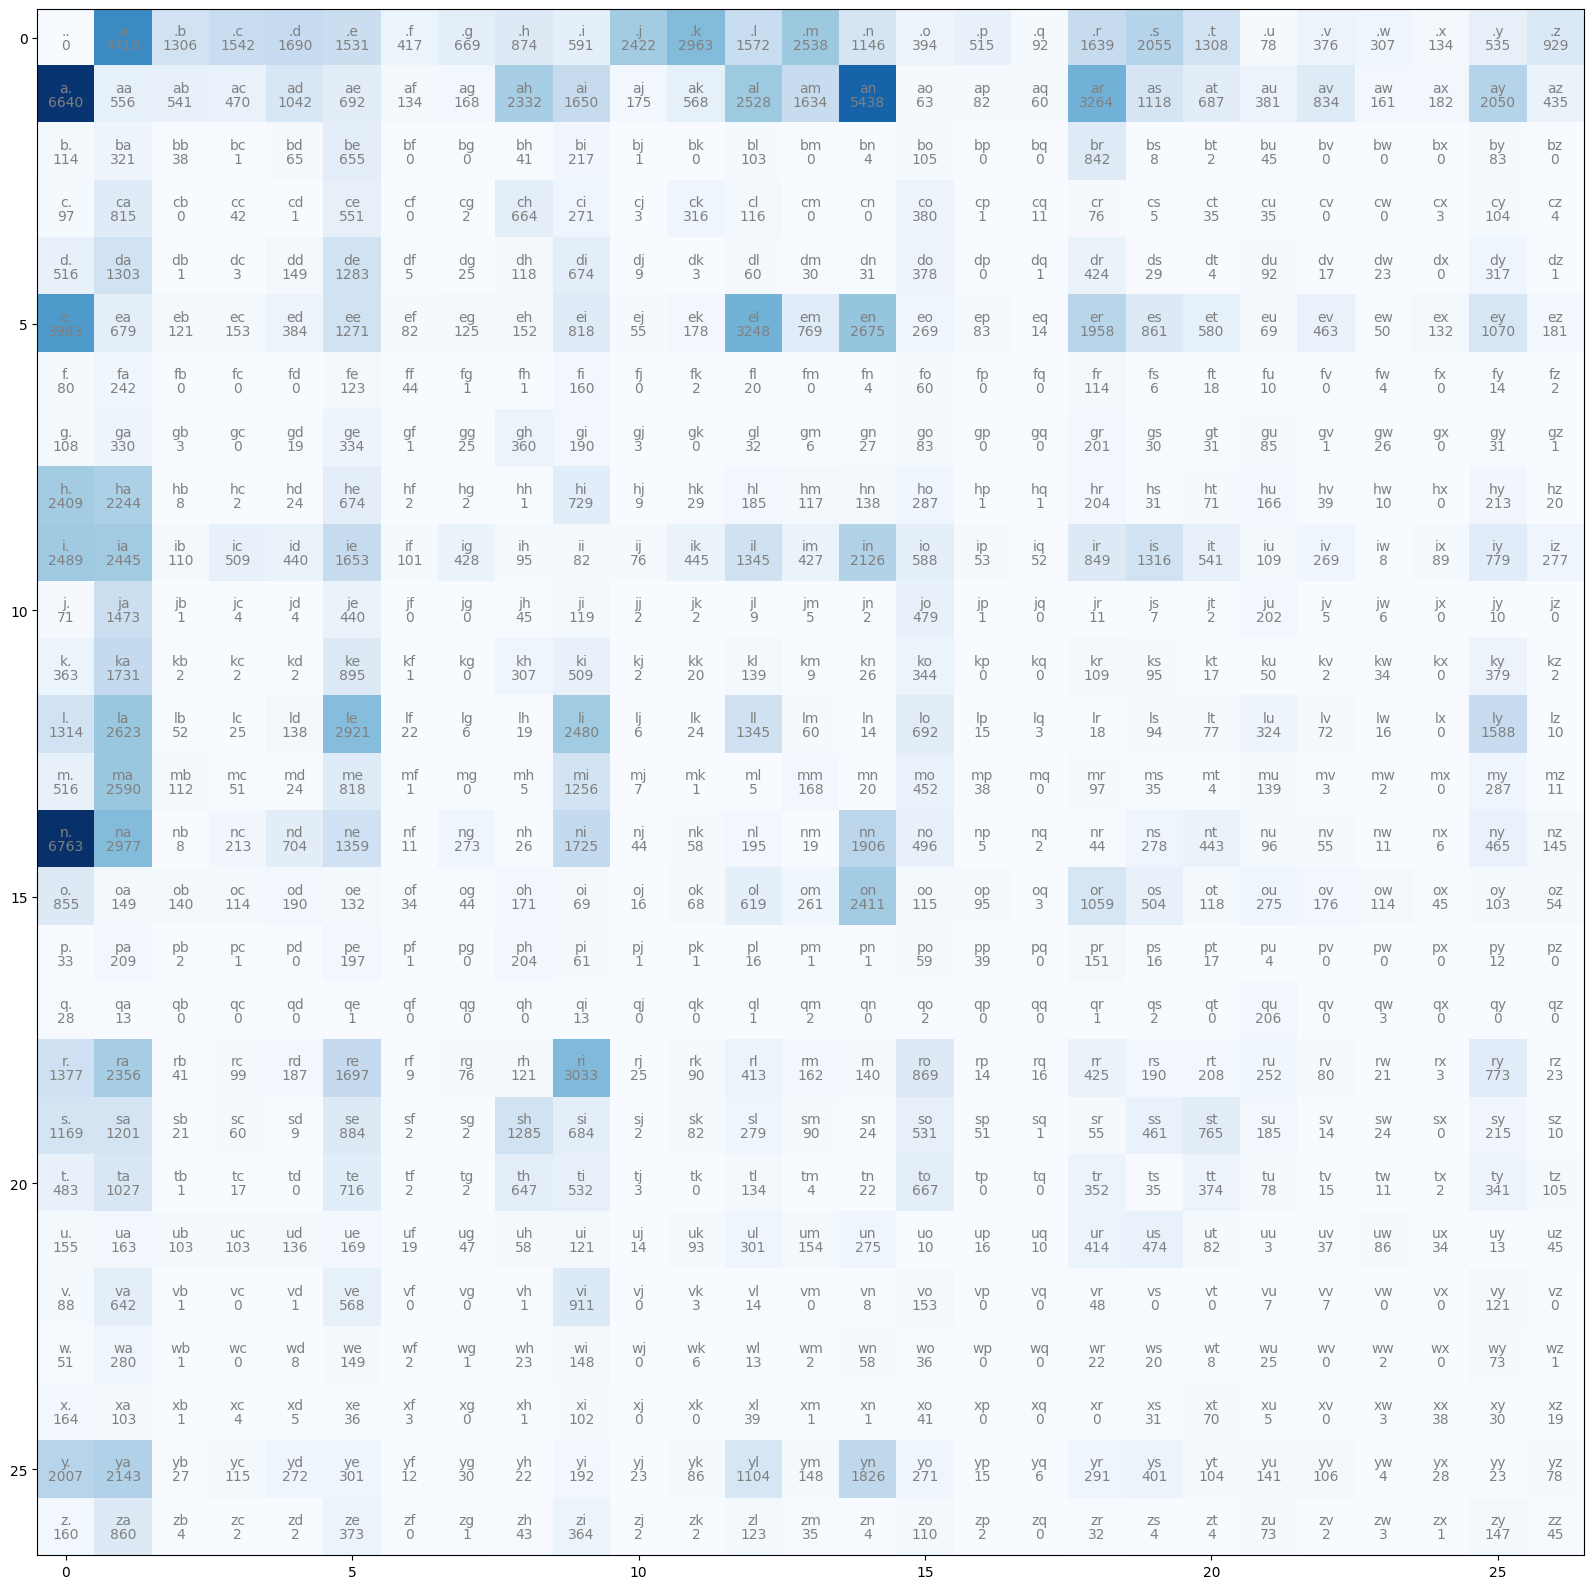

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha='center', va='bottom', color='gray')
        plt.text(j, i, N[i, j].item(), ha='center', va='top', color='gray')
plt.tight_layout()

In [14]:
N[0]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

In [15]:
p = N[0].float()
p = p / p.sum()
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [16]:
g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[ix]

'j'

In [17]:
P = (N + 1).float()
P /= P.sum(1, keepdim=True)

In [18]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
    out = []
    ix = 0
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

junide.
janasah.
p.
cony.
a.


In [19]:
log_likelihood = 0.0
n = 0
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        # print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

log_likelihood=tensor(-559951.5625)
nll=tensor(559951.5625)
2.4543561935424805


In [27]:
# create the training set of biagrams (x, y)

xs, ys = [], []

for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        print(ch1, ch2)
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

. e
e m
m m
m a
a .


In [28]:
xs

tensor([ 0,  5, 13, 13,  1])

In [29]:
ys

tensor([ 5, 13, 13,  1,  0])

In [34]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float()
xenc

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

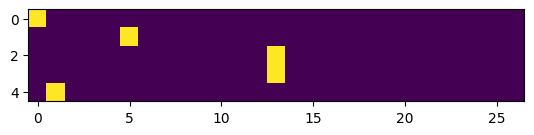

In [35]:
plt.imshow(xenc)

In [36]:
xenc.dtype

torch.float32

In [39]:
W = torch.randn((27, 27))
xenc @ W

tensor([[-1.1531e+00,  1.5526e+00, -1.8388e+00,  1.5873e+00,  1.6871e-01,
         -2.8775e-01, -7.8882e-01, -5.0041e-01, -1.1326e-01, -2.0857e+00,
         -9.0165e-01, -1.7750e+00,  1.4857e+00, -4.9157e-01,  3.0407e-01,
         -6.4332e-01,  1.4901e+00, -1.0583e+00,  1.1802e+00,  1.8614e+00,
         -3.9091e-01, -1.1165e+00, -3.6766e-01, -1.1104e+00,  1.0121e-01,
          7.8345e-01,  9.1353e-02],
        [ 5.2380e-01, -6.2489e-01, -1.9943e-01, -1.0352e+00, -1.7100e+00,
          1.5369e-01,  1.7903e+00, -2.1224e+00,  1.5495e+00, -2.7706e-01,
          1.1165e+00,  3.7299e-01, -1.4094e+00,  1.8013e+00, -1.3438e-01,
          1.8715e-01, -8.4537e-01,  8.6341e-02, -1.1038e-01, -6.1766e-01,
         -1.3852e+00,  7.3058e-04,  6.0690e-02,  2.9942e-01, -1.2715e+00,
          7.0111e-02, -5.8756e-01],
        [-1.2836e+00,  6.1318e-01,  5.5852e-01,  8.8730e-02,  1.5808e+00,
          2.9074e-01,  1.3842e+00, -2.7543e+00,  7.8577e-01,  1.9155e+00,
         -1.8476e-01, -5.6680e-01,  5.30

In [47]:
logits = xenc @ W # log counts
counts = logits.exp() # equivalent to the N matrix

probs = counts / counts.sum(1, keepdims=True)
probs

tensor([[0.0074, 0.1112, 0.0037, 0.1151, 0.0279, 0.0177, 0.0107, 0.0143, 0.0210,
         0.0029, 0.0096, 0.0040, 0.1040, 0.0144, 0.0319, 0.0124, 0.1045, 0.0082,
         0.0766, 0.1514, 0.0159, 0.0077, 0.0163, 0.0078, 0.0261, 0.0515, 0.0258],
        [0.0447, 0.0142, 0.0217, 0.0094, 0.0048, 0.0309, 0.1588, 0.0032, 0.1248,
         0.0201, 0.0809, 0.0385, 0.0065, 0.1605, 0.0232, 0.0320, 0.0114, 0.0289,
         0.0237, 0.0143, 0.0066, 0.0265, 0.0282, 0.0357, 0.0074, 0.0284, 0.0147],
        [0.0064, 0.0428, 0.0405, 0.0253, 0.1127, 0.0310, 0.0926, 0.0015, 0.0509,
         0.1575, 0.0193, 0.0132, 0.0394, 0.0132, 0.0128, 0.0283, 0.0124, 0.0063,
         0.0107, 0.0304, 0.0246, 0.0055, 0.0646, 0.0294, 0.0626, 0.0536, 0.0125],
        [0.0064, 0.0428, 0.0405, 0.0253, 0.1127, 0.0310, 0.0926, 0.0015, 0.0509,
         0.1575, 0.0193, 0.0132, 0.0394, 0.0132, 0.0128, 0.0283, 0.0124, 0.0063,
         0.0107, 0.0304, 0.0246, 0.0055, 0.0646, 0.0294, 0.0626, 0.0536, 0.0125],
        [0.0144, 0.1477,

In [48]:
probs.shape

torch.Size([5, 27])

In [54]:
probs[0].sum()

tensor(1.0000)

In [55]:
# SUMMARY ------------------------->>>>

In [56]:
xs

tensor([ 0,  5, 13, 13,  1])

In [57]:
ys

tensor([ 5, 13, 13,  1,  0])

In [62]:
# randomly initialize 27 neurons' weights. each nreuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
w = torch.randn((27, 27), generator=g)

In [63]:
xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot enconding
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for the next character

In [66]:
probs.shape

torch.Size([5, 27])

In [65]:
nlls = torch.zeros(5)
for i in range(5):
    # i-th biagram
    x = xs[i].item() # input character index
    y = ys[i].item() # label character index
    print('-------')
    print(f'biagram example {i+1}: {itos[x]}{itos[y]} (indexes {x},{y})')
    print('input to the neural net:', x)
    print('output probabilities from the neural net', probs[i])
    print('label (actual next character):', y)
    p = probs[i, y]
    print('probability assigned by the net to the correct character', p.item())
    logp = torch.log(p)
    print('log likelihood', logp.item())
    nll = -logp
    print('negative log likelihood', nll.item())
    nlls[i] = nll

print('=========')
print('average negative log likelihood, i.e. loss = ', nlls.mean().item())

-------
biagram example 1: .e (indexes 0,5)
input to the neural net: 0
output probabilities from the neural net tensor([0.0074, 0.1112, 0.0037, 0.1151, 0.0279, 0.0177, 0.0107, 0.0143, 0.0210,
        0.0029, 0.0096, 0.0040, 0.1040, 0.0144, 0.0319, 0.0124, 0.1045, 0.0082,
        0.0766, 0.1514, 0.0159, 0.0077, 0.0163, 0.0078, 0.0261, 0.0515, 0.0258])
label (actual next character): 5
probability assigned by the net to the correct character 0.017656046897172928
log likelihood -4.03667688369751
negative log likelihood 4.03667688369751
-------
biagram example 2: em (indexes 5,13)
input to the neural net: 5
output probabilities from the neural net tensor([0.0447, 0.0142, 0.0217, 0.0094, 0.0048, 0.0309, 0.1588, 0.0032, 0.1248,
        0.0201, 0.0809, 0.0385, 0.0065, 0.1605, 0.0232, 0.0320, 0.0114, 0.0289,
        0.0237, 0.0143, 0.0066, 0.0265, 0.0282, 0.0357, 0.0074, 0.0284, 0.0147])
label (actual next character): 13
probability assigned by the net to the correct character 0.160514831542968